<span style='color:blue'> The below is a 1-D solution considering all layers and a running yolk. I decided to look at half an egg using energy in at the center of the egg and tempt constant at the shell. The change in thermal properties are also accounted for using a process called The Apparent Specific Heat Method that accounts for latent heat or the spike in energy consumption that occurs at state change. This will look at the temperature at each location and adjust the alpha property (k/rho*Cp) accordingly. The first block of code was my first idea and is more proof of concept. The second cell can be run without the first. Most of the thermal values are guesses or from quick googles. Need to incorporate real values still. I'm open to ideas for what kind of plots we want to generate. I also need to add code for being able to adjust starting water temperature. I think I know how, just need to implement. </span>

In [1]:
import numpy as np
import time

# --- 1. Define Constants and Grid ---
# Values represent half an egg
R_yolk = 0.015  # 1.5 cm radius
R_white = 0.025 # 2.5 cm radius
R_shell = 0.027 # 2.7 cm radius

N_nodes = 100 # Total nodes
dr = R_shell / (N_nodes - 1)
r_nodes = np.linspace(0, R_shell, N_nodes)

T_initial = 17.0   # 4 C (fridge) or 16-18 C (room)
T_water = 100.0 # 100 C
h_conv = 1500   # Convection coefficient for boiling water

dt = 0.05 

# --- 2. Define Material Property Functions ---
def get_material(r):
    if r <= R_yolk: return "yolk"
    if r <= R_white: return "white"
    return "shell"

'''
    Need researched values for various ks here. 
    Would be nice to find a function. Google AI gave me 0.0013*T + 0.5125 for yolks
'''
def get_k(T, material):
    # Return k based on T and material type
    if material == "yolk":
        if T < 65: return 0.49  
        else: 
            return 0.45
    if material == "white":
        if T < 65: return 0.35
        else: 
            return 0.45
    else:
        return 2.2

'''
    Need real values and for temp and rho change.
'''
def get_rho(T, material):
    # Return density
    if material == "yolk":
        return 1025
    if material == "white":
        if T < 65:
            return 1035  
        else: 
            return 1100
    else:
        return 2150

'''
    Need real values and for temp and cp changes. Upper range is totally made up.
'''
def get_cp(T, material):
    if material == "white":
        if 60 < T < 70:
            return 15000 # Spike cp
        else:
            return 3200 # Normal cp
            
    if material == "yolk":
        if 65 < T < 72:
            return 10000 # Spike CP
        else:
            return 3500 # Normal cp
    else:
        return 8880

# --- 3. Initialization ---
T = np.full(N_nodes, T_initial)
T_new = np.copy(T)
time = 0.0    

# --- 4. Time-Stepping Loop ---
while True:
    
    # --- 5. Update Internal Nodes (i=1 to N-2) ---
    for i in range(1, N_nodes - 1):
        r = r_nodes[i]
        mat = get_material(r)
        
        # Get properties AT THIS NODE'S CURRENT TEMP
        k = get_k(T[i], mat)
        rho = get_rho(T[i], mat)
        cp = get_cp(T[i], mat)
        alpha = k / (rho * cp)
        
        # Explicit FDM for sphere
        term1 = (1 + 1/i) * T[i+1]
        term2 = -2 * T[i]
        term3 = (1 - 1/i) * T[i-1]
        
        T_new[i] = T[i] + alpha * (dt / dr**2) * (term1 + term2 + term3)
        
    # --- 6. Boundary Conditions ---
    # Center (i=0, Neumann)
    k = get_k(T[0], "yolk")
    rho = get_rho(T[0], "yolk")
    cp = get_cp(T[0], "yolk")
    alpha = k / (rho * cp)
    T_new[0] = T[0] + 6 * alpha * (dt / dr**2) * (T[1] - T[0])
    
    # Surface (i=N-1, Convection)
    k = get_k(T[-1], "shell")
    rho = get_rho(T[-1], "shell")
    cp = get_cp(T[-1], "shell")
    T_new[-1] = T[-1] + (2 * dt / (rho * cp * dr)) * ( (k / dr)*(T[-2] - T[-1]) + h_conv*(T_water - T[-1]) )

    # --- 7. Update Time and State ---
    T = np.copy(T_new)
    time += dt
    
    # --- 8. Check for "Runny Yolk" ---
    yolk_center_temp = T[0]
    white_temp = T[int(N_nodes * (R_white / R_shell)) - 1] # Temp at edge of white

    if white_temp > 65 and yolk_center_temp < 68:
        print(f"Runny yolk achieved at {time:.1f} seconds!")
        break
    
    if time > 1000: # Max cook time
        print("Egg is overcooked.")
        break

Runny yolk achieved at 147.0 seconds!


Starting simulation...
Simulation finished in 0.32 seconds.
Yolk edge begins to cook at 11.57 minutes


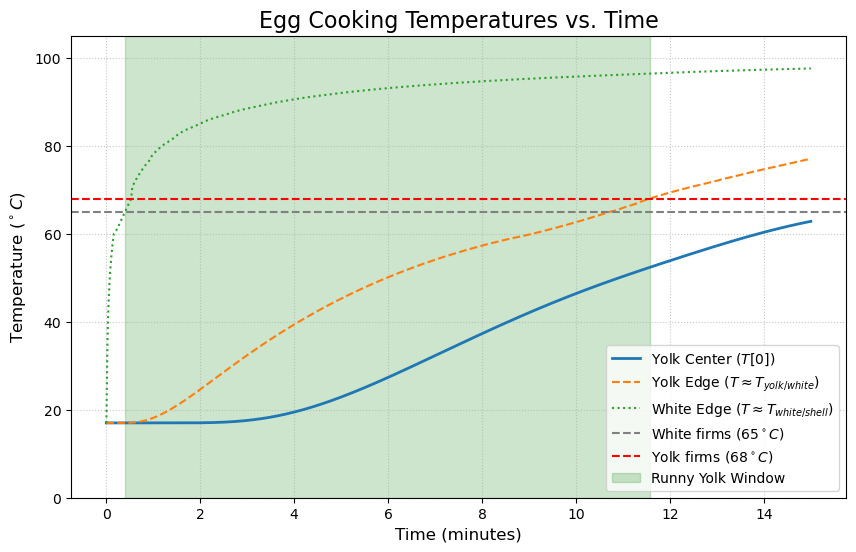

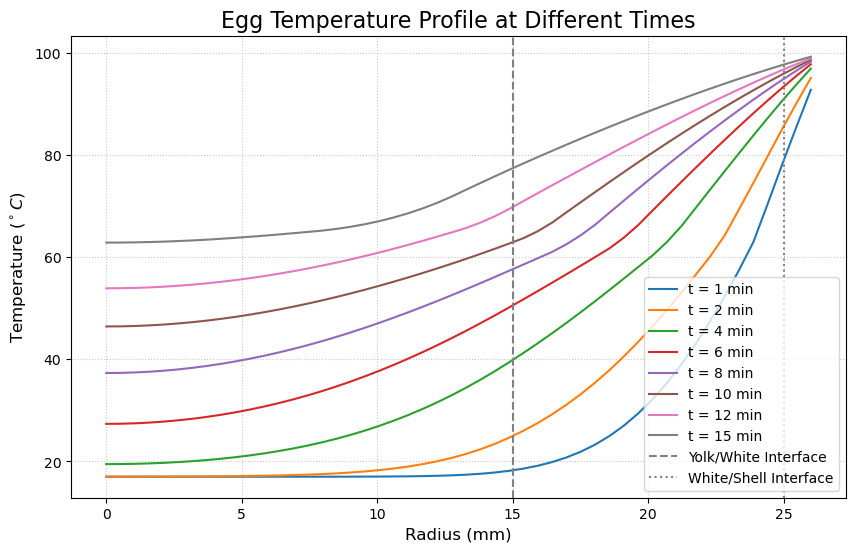

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_egg_simulation():
    """
    Runs a 1D FDM simulation of an egg cooking and plots the results.
    """
    
    # --- 1. Define Constants and Grid ---
    R_yolk = 0.015   # 1.5 cm radius
    R_white = 0.025  # 2.5 cm radius
    R_shell = 0.026  # 2.6 cm radius (1mm shell)

    N_nodes = 50   
    dr = R_shell / (N_nodes - 1)
    r_nodes = np.linspace(0, R_shell, N_nodes) # Radius at each node

    # Find interface indices
    yolk_white_idx = int(R_yolk / dr)
    white_shell_idx = int(R_white / dr)

    T_initial = 17.0    # 17 C (room temp) 4 C (from the fridge) - Found it takes ~ 1.5 minutes longer starting chilled
    T_water = 100.0  # 100 C
    h_conv = 1500.0    # Convection coeff for boiling water (W/m^2 K)

    # Time setup
    dt = 0.05    # Time step (Seconds)
    max_time = 900       # 15 minutes
    n_steps = int(max_time / dt)
    time_array = np.linspace(0, max_time, n_steps)

    # --- 2. Define Base Material Properties ---
    # Pre-populate property arrays
    k = np.zeros(N_nodes)
    rho = np.zeros(N_nodes)
    cp_base = np.zeros(N_nodes)

    # Yolk properties (i = 0 to yolk_white_idx)
    k[:yolk_white_idx] = 0.49
    rho[:yolk_white_idx] = 1032
    cp_base[:yolk_white_idx] = 3500 # 3.5 J/g*K * 1000 g/kg

    # White properties (i = yolk_white_idx to white_shell_idx)
    k[yolk_white_idx:white_shell_idx] = 0.58
    rho[yolk_white_idx:white_shell_idx] = 1040
    cp_base[yolk_white_idx:white_shell_idx] = 3700 # 3.7 J/g*K

    # Shell properties (i = white_shell_idx to end)
    k[white_shell_idx:] = 0.8
    rho[white_shell_idx:] = 2000
    cp_base[white_shell_idx:] = 800  # 0.8 J/g*K

    # --- 3. Initialization ---
    T = np.full(N_nodes, T_initial) # Temp array at current time 'p'
    T_new = np.copy(T)            # Temp array at next time 'p+1'

    # Data storage for plotting
    T_history_center = np.zeros(n_steps)
    T_history_yolk_edge = np.zeros(n_steps)
    T_history_white_edge = np.zeros(n_steps)

    # Storage for T(r) snapshots
    snapshot_times = [60, 120, 240, 360, 480, 600, 720, 900 ] # 1, 2, 4, 6, 8, 10, 12, 15 min
    snapshot_indices = [int(t / dt) - 1 for t in snapshot_times]
    T_snapshots = []

    # Get node indices for vectorization
    i = np.arange(1, N_nodes - 1) # Internal nodes
    
    print("Starting simulation...")
    start_time = time.time()
    
    # --- 4. Time-Stepping Loop ---
    for p in range(n_steps):
        
        # --- 4a. Update Apparent Specific Heat (The "cooking") ---
        # This models the latent heat of denaturation
        cp = np.copy(cp_base)
        
        # Yolk spike: 65C to 72C
        yolk_cooking = (r_nodes <= R_yolk) & (T > 65) & (T < 72)
        cp[yolk_cooking] = 10000 # 10.0 J/g*K
        
        # White spike: 60C to 68C
        white_cooking = (r_nodes > R_yolk) & (r_nodes <= R_white) & (T > 60) & (T < 68)
        cp[white_cooking] = 15000 # 15.0 J/g*K
        
        # Calculate thermal diffusivity for all nodes
        alpha = k / (rho * cp)
        
        # --- 4b. Update Internal Nodes (Vectorized) ---
        T_plus_1 = T[2:]     # T[i+1]
        T_minus_1 = T[:-2]   # T[i-1]
        T_i = T[1:-1]        # T[i]
        
        term1 = (1 + 1/i) * T_plus_1
        term2 = -2 * T_i
        term3 = (1 - 1/i) * T_minus_1
        
        T_new[1:-1] = T_i + (alpha[1:-1] * dt / dr**2) * (term1 + term2 + term3)
        
        # --- 4c. Boundary Conditions ---
        
        # Center (i=0, Constant T)
        T_new[0] = T[0] + 6 * alpha[0] * (dt / dr**2) * (T[1] - T[0])
        
        # Surface (i=N-1, Energy Balance)
        k_shell = k[-1]; rho_shell = rho[-1]; cp_shell = cp[-1]
        
        term_cond = (k_shell / dr) * (T[-2] - T[-1])
        term_conv = h_conv * (T_water - T[-1])
        
        T_new[-1] = T[-1] + (2 * dt / (rho_shell * cp_shell * dr)) * (term_cond + term_conv)

        # --- 4d. Update State & Store Data ---
        T = np.copy(T_new)
        
        T_history_center[p] = T[0]
        T_history_yolk_edge[p] = T[yolk_white_idx]
        T_history_white_edge[p] = T[white_shell_idx]

        if p in snapshot_indices:
            T_snapshots.append((snapshot_times[snapshot_indices.index(p)], np.copy(T)))

    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
    
    # --- 5. Plotting ---
    
    # === PLOT 1: Temperature vs. Time ===
    plt.figure(figsize=(10, 6))
    plt.plot(time_array / 60, T_history_center, label=r'Yolk Center ($T[0]$)', lw=2)
    plt.plot(time_array / 60, T_history_yolk_edge, label=r'Yolk Edge ($T \approx T_{yolk/white}$)', ls='--')
    plt.plot(time_array / 60, T_history_white_edge, label=r'White Edge ($T \approx T_{white/shell}$)', ls=':')
    
    # Add cooking temperature lines
    plt.axhline(65, color='gray', linestyle='--', label=r'White firms ($65^\circ C$)')
    plt.axhline(68, color='red', linestyle='--', label=r'Yolk firms ($68^\circ C$)')
    
    # Shade the "runny yolk" region
    try:
        white_cooked_time = np.where(T_history_white_edge > 65)[0][0] * dt / 60
        yolk_cooked_time = np.where(T_history_yolk_edge > 68)[0][0] * dt / 60
        plt.axvspan(white_cooked_time, yolk_cooked_time, color='green', alpha=0.2, label='Runny Yolk Window')
    except IndexError:
        print("Yolk is still runny after simulated time")

    # Report time yolk begins to cook
    try:
        yolk_edge_index = np.where(T_history_yolk_edge > 68)[0][0]
        yolk_edge_time = yolk_edge_index * dt / 60
        print(f"Yolk edge begins to cook at {yolk_edge_time:.2f} minutes")
        
    except IndexError:
        print("The yolk edge did not reach 68C in this simulation.")
        
    plt.title('Egg Cooking Temperatures vs. Time', fontsize=16)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Temperature ($^\circ C$)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(0, 105) # From fridge temp to water temp
    #plt.savefig('egg_temp_vs_time.png', dpi=300)
    #print("Saved 'egg_temp_vs_time.png'")

    # === PLOT 2: Temperature vs. Radius (Snapshots) ===
    plt.figure(figsize=(10, 6))
    
    for (t, T_profile) in T_snapshots:
        plt.plot(r_nodes * 1000, T_profile, label=f't = {t/60:.0f} min')

    # Add material boundaries
    plt.axvline(R_yolk * 1000, color='gray', linestyle='--', label='Yolk/White Interface')
    plt.axvline(R_white * 1000, color='gray', linestyle=':', label='White/Shell Interface')
    
    plt.title('Egg Temperature Profile at Different Times', fontsize=16)
    plt.xlabel('Radius (mm)', fontsize=12)
    plt.ylabel('Temperature ($^\circ C$)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    #plt.savefig('egg_temp_profile.png', dpi=300)
    #print("Saved 'egg_temp_profile.png'")

# Run the simulation
run_egg_simulation()